<a href="https://colab.research.google.com/github/huggingface/data-is-better-together/blob/main/prompt_translation/setup_prompt_translation_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install huggingface_hub argilla datasets openai -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.

# Steps

The overall steps to create a new Argilla Space for translating a new language are as follows:

1. Setup an organization on the Hub
2. Create an Argilla Space
3. Setup the Space secrets
4. Load the DIBT data into the Argilla Space
5. Begin translating the data!


This notebook will walk through step 1-3. Some of the steps are done using the `huggingface_hub` CLI, other parts of the process can only be done in the UI, but we will also show how to do them using the API.




In [2]:
from huggingface_hub import duplicate_space
from huggingface_hub import hf_hub_download
from huggingface_hub import HfApi
from huggingface_hub import SpaceCard
import yaml
import json

## 1. Create a new organization for your language effort

To make it easier to keep track of your language effort, we recommend creating a new organization for your language effort. This will allow you to keep all of your language effort data in one place. We suggest naming this organization "DIBT-{language}" where `{language}` is the name of your language. For example, if you are working on the language "Spanish", you would name your organization "DIBT-Spanish". This will make it easier for us to track all of the DIBT language efforts.

You can use this link to create a new organization on the Hub: [https://huggingface.co/organizations/new](https://huggingface.co/organizations/new).

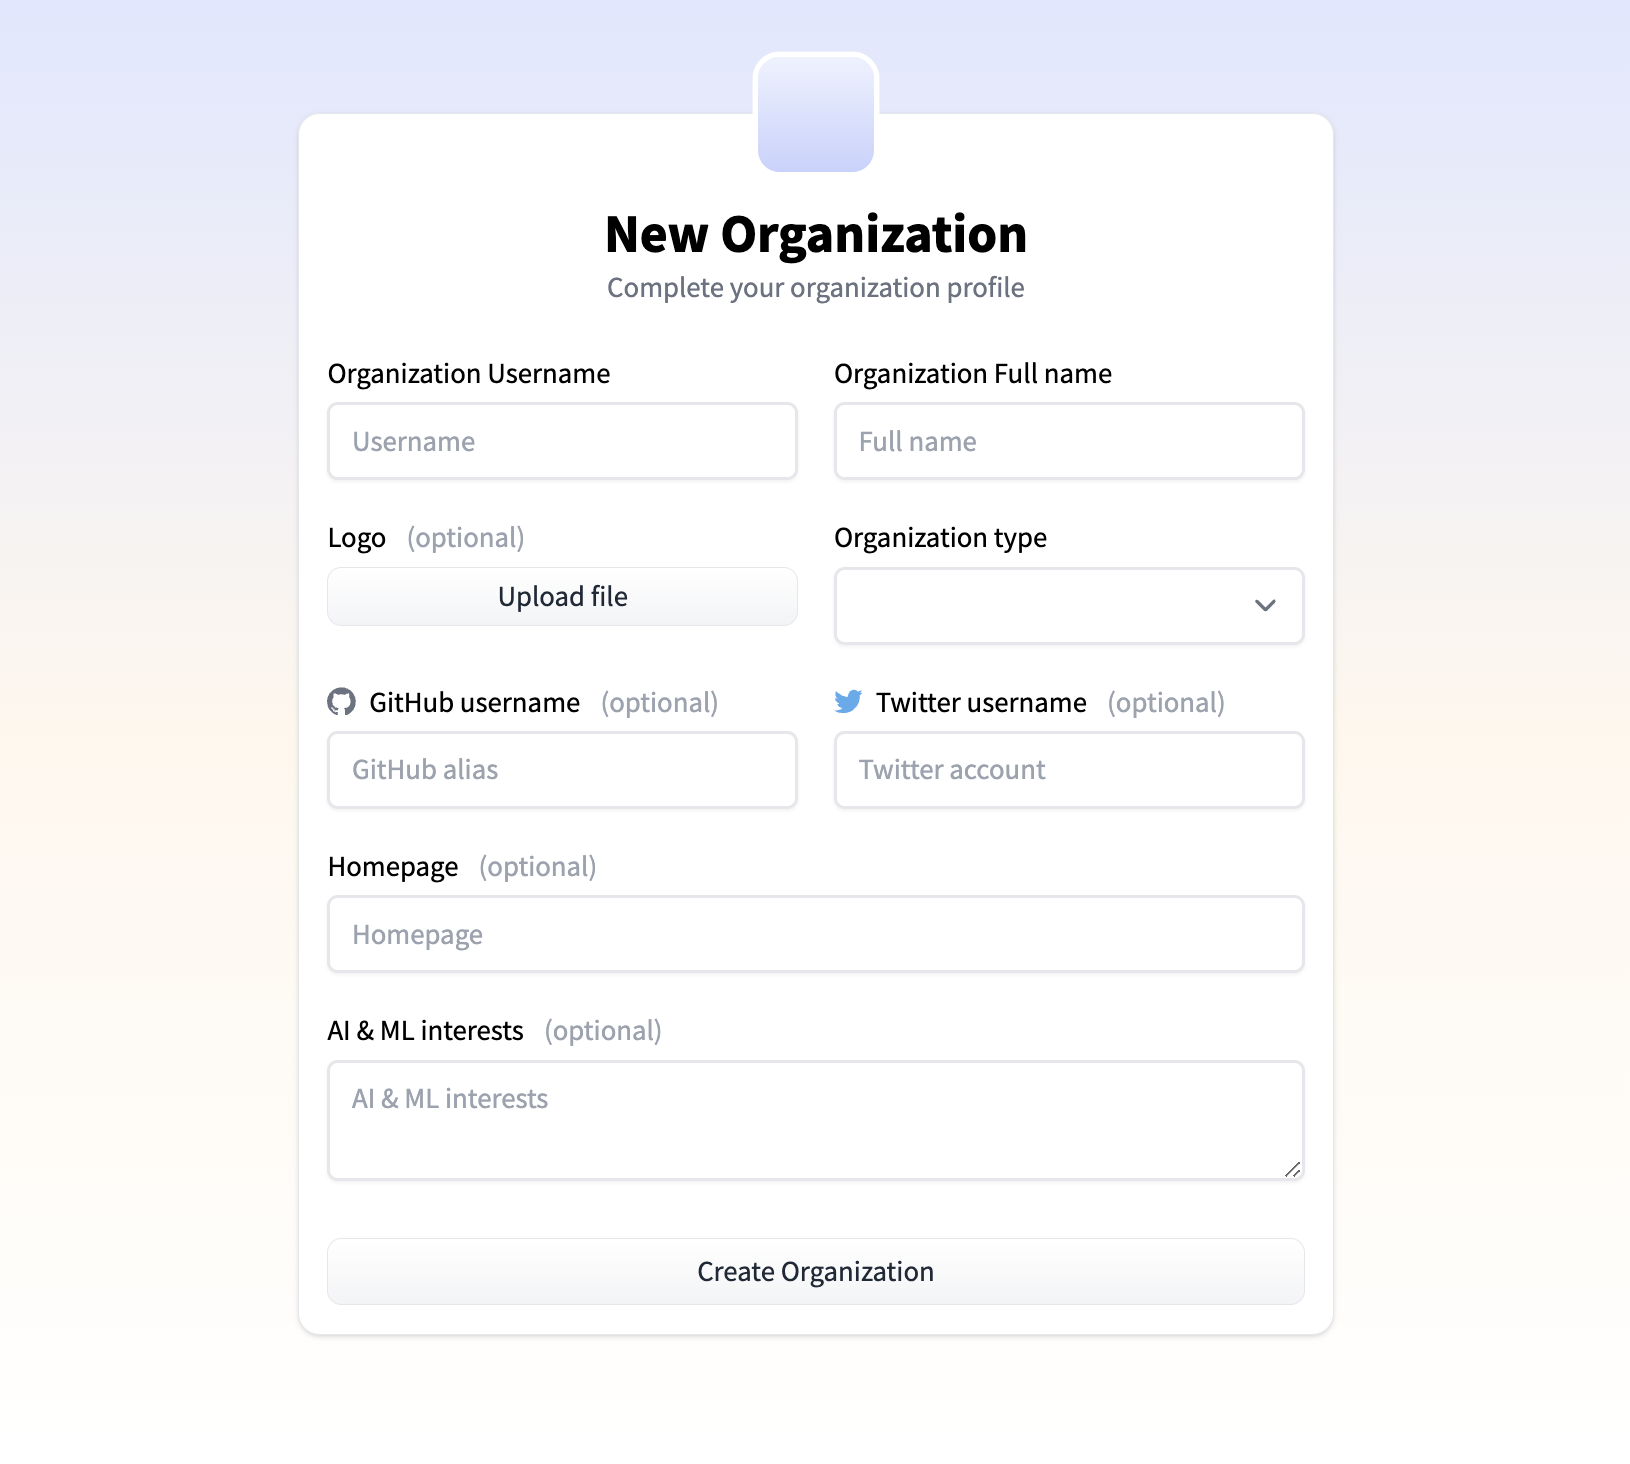



<div class="alert alert-warning">
  <strong>Tip!</strong> Make sure you update this section with your details
</div>

In [ ]:
HF_ORG_NAME = None # update with the ID of the org you just created
LANGUAGE = None # update this with the language you will work on

In [ ]:
assert HF_ORG_NAME is not None, "Please set HF_ORG_NAME to the ID of the Hugging Face org you just created"
assert LANGUAGE is not None, "Please set LANGUAGE to the language your effort focuses on"

*Note** please ping `@dvs13` in the Discord channel once you have created your organization.

## 2. Setup the Space

We will use the `huggingface_hub` CLI to create a new Space for our language effort by cloning an existing template Space. We could also do this via the UI but we'll also update some of the settings using the API in this notebook to reduce the amount of steps you need to do in the UI. Before we do this we need to authenticate with the Hub.

In [ ]:
from huggingface_hub import login

In [ ]:
login()

In [ ]:
api = HfApi()

This step duplicates the existing Argilla Space to your organization.

In [ ]:
from_id = "argilla/argilla-template-space-with-oauth"
to_id =  f"{HF_ORG_NAME}/prompt-translation-for-{LANGUAGE}"
new_space = duplicate_space(from_id, to_id=to_id)
new_space

We update the tile and description of the Space to reflect the language we are translating.

In [ ]:
card = SpaceCard.load(to_id)
card.data.title = f"DIBT Translation for {LANGUAGE}"
card.push_to_hub(to_id)

## 3. Create an application on the Hub

To enable the Oauth integration we need to create an application on the Hub. We can do this via the Hugging Face settings UI.

- Go to this page: [https://huggingface.co/settings/applications/new](https://huggingface.co/settings/applications/new)
- Complete the form to create a new application. You will need to provide the following values:
    - Name of application
    - Homepage URL: Your Argilla Space Direct URL.
    - Logo URL: [Your Argilla Space Direct URL]/favicon.ico
    - Scopes: openid and profile.
    - Redirect URL: [Your Argilla Space Direct URL]/oauth/huggingface/callback

The cell below will show you the URL for these values.



In [ ]:
homepage_url = f"https://{new_space.repo_id.lower().replace('/', '-')}.hf.space"
favicon_url = f"{homepage_url.lower()}/favicon.ico"
redirect_url = f"{homepage_url.lower()}/oauth/huggingface/callback"
print(f"Homepage URL: {homepage_url.lower()} \n Logo URL: {favicon_url} \n Redirect URL: {redirect_url}")

Homepage URL: https://somosnlp-prompt-translation-for-spanish.hf.space 
 Logo URL: https://somosnlp-prompt-translation-for-spanish.hf.space/favicon.ico 
 Redirect URL: https://somosnlp-prompt-translation-for-spanish.hf.space/oauth/huggingface/callback


## 4. Setup your Space secrets

Once we have created the application we will need to update our Space secrets to add these values which will be shown once you've created your application using the steps above.

- `OAUTH2_HUGGINGFACE_CLIENT_ID`: [Your Client ID]
- `OAUTH2_HUGGINGFACE_CLIENT_SECRET` : [Your App Secret]

Additionally, we highly recommend setting up a custom API_KEY and PASSWORD for the owner role (you). This owner role would be the only one allowed to create, delete, read and update datasets, so it's important to change the defaults:

- `OWNER_API_KEY`: you can put any alphanumeric value
- `OWNER_PASSWORD`: at least 8 digits/characters.

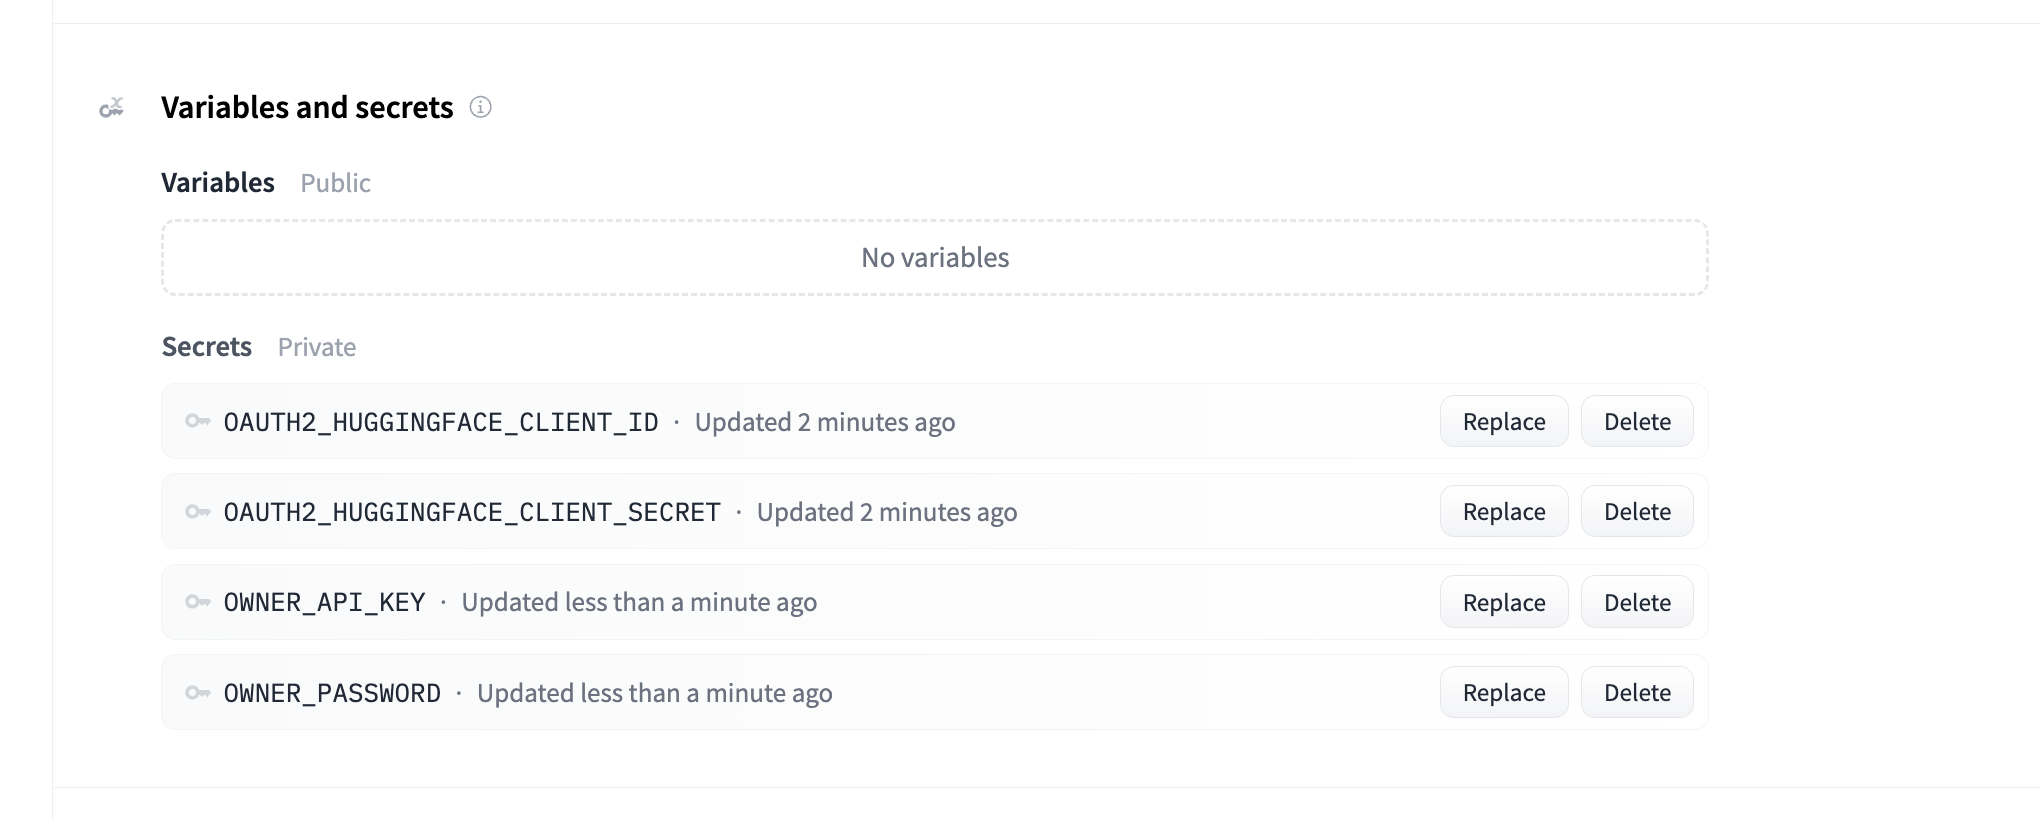


You can add these secrets via the `settings` tab in the UI. Run the cell below and click on the link:

In [ ]:
print(f"https://huggingface.co/spaces/{to_id}/settings")

https://huggingface.co/spaces/somosnlp/prompt-translation-for-Spanish/settings


## 5. Persistent Storage + Upgrade CPU

To ensure all annotations are safely stored we'll want to enable persistent storage on our Space. This means that if the Space is stopped and restarted, all annotations will still be available. Please ping `@.dvs13` on Discord to enable this feature for your Space.

Additionally, we'll upgrade the CPU and disable sleeping to ensure the Space is always available for annotators!

We now need to factory reset the Space to ensure all of the above changes register.

In [ ]:
from huggingface_hub import restart_space

restart_space(to_id, factory_reboot=True)

## Next step

Once you have gotten the confirmation that the above steps have been completed, we can move to the next notebook and upload the data to the Argilla Space.